# Action Conditional Deep Markov Model using cartpole dataset

In [1]:
from tqdm import tqdm

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from tensorboardX import SummaryWriter
import numpy as np

from utils import DMMDataset, imshow
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

seed = 1
torch.manual_seed(seed)
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


## Prepare Dataset 
you have to run prepare_cartpole_dataset.py or download from :  
https://drive.google.com/drive/folders/1w_97RLFS--CpdUCNw1C-3yPLhceZxkO2?usp=sharing

In [2]:
# you have to run prepare_cartpole_dataset.py or download from :
batch_size = 256
train_loader = DataLoader(DMMDataset(), batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader = DataLoader(DMMTestDataset(), batch_size=batch_size, shuffle=False, drop_last=True)

_x = iter(train_loader).next()

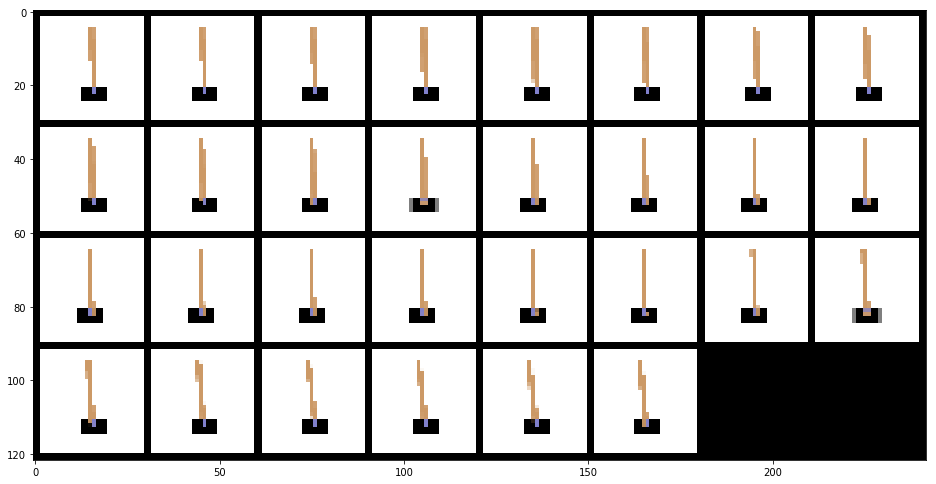

tensor([[0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])


In [3]:
imshow(_x['episode_frames'][0][0:30])

# 0: Push cart to the left
# 1:Push cart to the right
print(_x['actions'][0][0:30])

# for more details about actions: https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/classic_control/cartpole.py#L37
# for more details about CartPole-v1: https://gym.openai.com/envs/CartPole-v1/

In [4]:
from pixyz.utils import print_latex
from pixyz.distributions import Bernoulli, Normal, Deterministic


h_dim = 32
hidden_dim = 32
z_dim = 16
t_max = 30
u_dim = 1

## Deep Markov Model
* Original paper: Structured Inference Networks for Nonlinear State Space Models (https://arxiv.org/abs/1609.09869)
* Original code: https://github.com/clinicalml/dmm


Prior(Transition model): $p_{\theta}(z_{t} | z_{t-1}, u) =  \cal{N}(\mu = f_{prior_\mu}(z_{t-1}, u), \sigma^2 = f_{prior_\sigma^2}(z_{t-1}, u)$    
Generator(Emission): $p_{\theta}(x | z)=\mathscr{B}\left(x ; \lambda=g_{x}(z)\right)$  

RNN: $p(h) = RNN(x)$  
Inference(Combiner): $p_{\phi}(z | h, z_{t-1}, u) = \cal{N}(\mu = f_{\mu}(h, z_{t-1}, u), \sigma^2 = f_{\sigma^2}(h, z_{t-1}, u)$

## Define probability distributions

In [5]:
# RNN
class RNN(Deterministic):
    """
    h = RNN(x)
    Given observed x, RNN output hidden state
    """
    def __init__(self):
        super(RNN, self).__init__(cond_var=["x"], var=["h"])
        
        # 28x28x3 → 32
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(128*7*7, 256)
        self.fc2 = nn.Linear(256, 32)
        
        self.rnn = nn.GRU(32, h_dim, bidirectional=True)
        self.h0 = nn.Parameter(torch.zeros(2, 1, self.rnn.hidden_size))
        self.hidden_size = self.rnn.hidden_size
        
    def forward(self, x):
        
        h0 = self.h0.expand(2, x.size(1), self.rnn.hidden_size).contiguous()
        x = x.reshape(-1, 3, 28, 28)      # Nx3x28x28

        h = F.relu(self.conv1(x))         # Nx64x14x14
        h = F.relu(self.conv2(h))         # Nx128x7x7
        h = h.view(h.shape[0], 128*7*7)   # Nx128*7*7
        h = F.relu(self.fc1(h))           # Nx256
        h = F.relu(self.fc2(h))           # Nx32
        h = h.reshape(30, -1, 32)         # 30x128x32

        h, _ = self.rnn(h, h0)            # 30x128x32, 1x128x32
        return {"h": h}


# Emission p(x_t | z_t)
class Generator(Bernoulli):
    """
    Given the latent z at time step t, return the vector of
    probabilities that parameterizes the bernlulli distribution p(x_t | z_t)
    """
    def __init__(self):
        super(Generator, self).__init__(cond_var=["z"], var=["x"])
        self.fc1 = nn.Linear(z_dim, 256)
        self.fc2 = nn.Linear(256, 128*7*7)
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)        

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        h = h.view(h.shape[0], 128, 7, 7) # 128*7*7
        h = F.relu(self.conv1(h))         # 64x14x14
        generated_x = self.conv2(h)                 # 3x28x28
        return {"probs": torch.sigmoid(generated_x)}


class Inference(Normal):
    """
    given the latent z at time step t-1, the hidden state of the RNN h(x_{0:T} and u
    return the loc and scale vectors that
    parameterize the gaussian distribution q(z_t | z_{t-1}, x_{t:T}, u)
    """
    def __init__(self):
        super(Inference, self).__init__(cond_var=["h", "z_prev", "u"], var=["z"])
        self.fc1 = nn.Linear(z_dim+u_dim, h_dim*2)
        self.fc21 = nn.Linear(h_dim*2, z_dim)
        self.fc22 = nn.Linear(h_dim*2, z_dim)

        
    def forward(self, h, z_prev, u):
        feature = torch.cat((z_prev, u), 1)
        h_z = torch.tanh(self.fc1(feature))
        h = 0.5 * (h + h_z)
        return {"loc": self.fc21(h), "scale": F.softplus(self.fc22(h))}


class Prior(Normal):
    """
    Given the latent variable at the time step t-1 and u,
    return the mean and scale vectors that parameterize the
    gaussian distribution p(z_t | z_{t-1}, u)
    """
    def __init__(self):
        super(Prior, self).__init__(cond_var=["z_prev", "u"], var=["z"])
        self.fc1 = nn.Linear(z_dim+u_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        
    def forward(self, z_prev, u):
        feature = torch.cat((z_prev, u), 1)
        h = F.relu(self.fc1(feature))
        return {"loc": self.fc21(h), "scale": F.softplus(self.fc22(h))}

In [6]:
prior = Prior().to(device)
encoder = Inference().to(device)
decoder = Generator().to(device)
rnn = RNN().to(device)
generate_from_prior = prior * decoder

print_latex(generate_from_prior)

<IPython.core.display.Math object>

## Define loss

In [7]:
from pixyz.losses import KullbackLeibler
from pixyz.losses import Expectation as E
from pixyz.losses import LogProb
from pixyz.losses import IterativeLoss

step_loss = - E(encoder, LogProb(decoder)) + KullbackLeibler(encoder, prior)

# IterativeLoss: https://docs.pixyz.io/en/latest/losses.html#pixyz.losses.IterativeLoss
_loss = IterativeLoss(step_loss, max_iter=t_max, 
                      series_var=["x", "h", "u"], update_value={"z": "z_prev"})
loss = E(rnn, _loss).mean()

In [8]:
from pixyz.models import Model

dmm = Model(loss, distributions=[rnn, encoder, decoder, prior], 
            optimizer=optim.RMSprop, optimizer_params={"lr": 5e-4}, clip_grad_value=10)

print(dmm)
print_latex(dmm)

Distributions (for training): 
  p(h|x), p(z|h,z_{prev},u), p(x|z), p(z|z_{prev},u) 
Loss function: 
  mean \left(\mathbb{E}_{p(h|x)} \left[\sum_{t=1}^{30} \left(D_{KL} \left[p(z|h,z_{prev},u)||p(z|z_{prev},u) \right] - \mathbb{E}_{p(z|h,z_{prev},u)} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  RMSprop (
  Parameter Group 0
      alpha: 0.99
      centered: False
      eps: 1e-08
      lr: 0.0005
      momentum: 0
      weight_decay: 0
  )


<IPython.core.display.Math object>

## Sampling code

In [9]:
def data_loop(epoch, loader, model, device, train_mode=False):
    mean_loss = 0
    for data in loader:
        x = data['episode_frames'].to(device) # 256,30,3,28,28
        u = data['actions'].to(device) # 256,30,1
        batch_size = x.size()[0]
        x = x.transpose(0, 1) # 30,256,3,28,28
        u = u.transpose(0, 1) # 30,256,1
        z_prev = torch.zeros(batch_size, z_dim).to(device)
        if train_mode:
            mean_loss += model.train({'x': x, 'z_prev': z_prev, 'u': u}).item() * batch_size
        else:
            mean_loss += model.test({'x': x, 'z_prev': z_prev, 'u': u}).item() * batch_size
    mean_loss /= len(loader.dataset)
    if train_mode:
        print('Epoch: {} Train loss: {:.4f}'.format(epoch, mean_loss))
    else:
        print('Test loss: {:.4f}'.format(mean_loss))
    return mean_loss

_data = iter(train_loader).next()
_u = _data['actions'].to(device) # 256,30,1
_u = _u.transpose(0, 1)          # 30,256,1

def plot_video_from_latent(batch_size):
    x = []
    z_prev = torch.zeros(batch_size, z_dim).to(device)
    for step in range(t_max):
        samples = generate_from_prior.sample({'z_prev': z_prev, 'u': _u[step]})
        x_t = decoder.sample_mean({"z": samples["z"]})
        z_prev = samples["z"]
        x.append(x_t[None, :])
    x = torch.cat(x, dim=0).transpose(0, 1)
    return x

## Train

  0%|          | 1/200 [00:03<11:42,  3.53s/it]

Epoch: 1 Train loss: 25165.2360


  1%|          | 2/200 [00:07<11:43,  3.55s/it]

Epoch: 2 Train loss: 9130.1990


  2%|▏         | 3/200 [00:10<11:37,  3.54s/it]

Epoch: 3 Train loss: 6401.8344


  2%|▏         | 4/200 [00:14<11:33,  3.54s/it]

Epoch: 4 Train loss: 5604.6350


  2%|▎         | 5/200 [00:17<11:30,  3.54s/it]

Epoch: 5 Train loss: 5250.0818


  3%|▎         | 6/200 [00:21<11:25,  3.54s/it]

Epoch: 6 Train loss: 5136.6165


  4%|▎         | 7/200 [00:24<11:22,  3.53s/it]

Epoch: 7 Train loss: 5041.2250


  4%|▍         | 8/200 [00:28<11:18,  3.53s/it]

Epoch: 8 Train loss: 4976.7343


  4%|▍         | 9/200 [00:31<11:14,  3.53s/it]

Epoch: 9 Train loss: 4947.8100


  5%|▌         | 10/200 [00:35<11:11,  3.53s/it]

Epoch: 10 Train loss: 4868.6670


  6%|▌         | 11/200 [00:38<11:08,  3.54s/it]

Epoch: 11 Train loss: 4887.0091


  6%|▌         | 12/200 [00:42<11:05,  3.54s/it]

Epoch: 12 Train loss: 4818.7775


  6%|▋         | 13/200 [00:46<11:01,  3.54s/it]

Epoch: 13 Train loss: 4782.6232


  7%|▋         | 14/200 [00:49<10:58,  3.54s/it]

Epoch: 14 Train loss: 4773.8522


  8%|▊         | 15/200 [00:53<10:55,  3.54s/it]

Epoch: 15 Train loss: 4742.7823


  8%|▊         | 16/200 [00:56<10:52,  3.54s/it]

Epoch: 16 Train loss: 4727.1570


  8%|▊         | 17/200 [01:00<10:48,  3.54s/it]

Epoch: 17 Train loss: 4696.7326


  9%|▉         | 18/200 [01:03<10:45,  3.55s/it]

Epoch: 18 Train loss: 4734.9274


 10%|▉         | 19/200 [01:07<10:41,  3.55s/it]

Epoch: 19 Train loss: 4708.8597


 10%|█         | 20/200 [01:10<10:38,  3.55s/it]

Epoch: 20 Train loss: 4635.5423


 10%|█         | 21/200 [01:14<10:35,  3.55s/it]

Epoch: 21 Train loss: 4662.6501


 11%|█         | 22/200 [01:18<10:31,  3.55s/it]

Epoch: 22 Train loss: 4617.7811


 12%|█▏        | 23/200 [01:21<10:28,  3.55s/it]

Epoch: 23 Train loss: 4629.0972


 12%|█▏        | 24/200 [01:25<10:25,  3.55s/it]

Epoch: 24 Train loss: 4630.6133


 12%|█▎        | 25/200 [01:28<10:21,  3.55s/it]

Epoch: 25 Train loss: 4623.1689


 13%|█▎        | 26/200 [01:32<10:18,  3.55s/it]

Epoch: 26 Train loss: 4580.3945


 14%|█▎        | 27/200 [01:35<10:14,  3.55s/it]

Epoch: 27 Train loss: 4583.2993


 14%|█▍        | 28/200 [01:39<10:11,  3.55s/it]

Epoch: 28 Train loss: 4596.0267


 14%|█▍        | 29/200 [01:43<10:07,  3.56s/it]

Epoch: 29 Train loss: 4537.0640


 15%|█▌        | 30/200 [01:46<10:04,  3.56s/it]

Epoch: 30 Train loss: 4525.9952


 16%|█▌        | 31/200 [01:50<10:01,  3.56s/it]

Epoch: 31 Train loss: 4490.8614


 16%|█▌        | 32/200 [01:53<09:57,  3.56s/it]

Epoch: 32 Train loss: 4462.6433


 16%|█▋        | 33/200 [01:57<09:54,  3.56s/it]

Epoch: 33 Train loss: 4387.5721


 17%|█▋        | 34/200 [02:01<09:51,  3.56s/it]

Epoch: 34 Train loss: 4267.6621


 18%|█▊        | 35/200 [02:04<09:47,  3.56s/it]

Epoch: 35 Train loss: 4188.8135


 18%|█▊        | 36/200 [02:08<09:44,  3.56s/it]

Epoch: 36 Train loss: 4096.4102


 18%|█▊        | 37/200 [02:11<09:40,  3.56s/it]

Epoch: 37 Train loss: 4677.2219


 19%|█▉        | 38/200 [02:15<09:37,  3.56s/it]

Epoch: 38 Train loss: 3991.7929


 20%|█▉        | 39/200 [02:19<09:34,  3.57s/it]

Epoch: 39 Train loss: 3994.9256


 20%|██        | 40/200 [02:22<09:30,  3.57s/it]

Epoch: 40 Train loss: 3920.9626


 20%|██        | 41/200 [02:26<09:27,  3.57s/it]

Epoch: 41 Train loss: 3933.4977


 21%|██        | 42/200 [02:29<09:23,  3.57s/it]

Epoch: 42 Train loss: 3915.6800


 22%|██▏       | 43/200 [02:33<09:20,  3.57s/it]

Epoch: 43 Train loss: 3884.8615


 22%|██▏       | 44/200 [02:37<09:16,  3.57s/it]

Epoch: 44 Train loss: 3864.7660


 22%|██▎       | 45/200 [02:40<09:13,  3.57s/it]

Epoch: 45 Train loss: 3851.0302


 23%|██▎       | 46/200 [02:44<09:09,  3.57s/it]

Epoch: 46 Train loss: 3855.2326


 24%|██▎       | 47/200 [02:47<09:06,  3.57s/it]

Epoch: 47 Train loss: 3830.1528


 24%|██▍       | 48/200 [02:51<09:02,  3.57s/it]

Epoch: 48 Train loss: 3800.6746


 24%|██▍       | 49/200 [02:55<08:59,  3.57s/it]

Epoch: 49 Train loss: 3800.0325
Epoch: 50 Train loss: 3764.9729


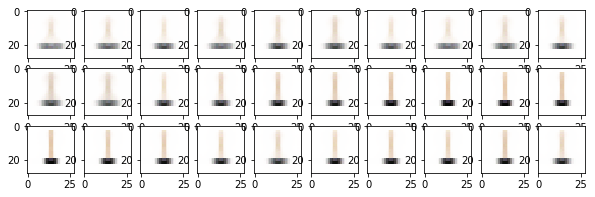

 26%|██▌       | 51/200 [03:03<08:56,  3.60s/it]

Epoch: 51 Train loss: 3750.0143


 26%|██▌       | 52/200 [03:07<08:52,  3.60s/it]

Epoch: 52 Train loss: 3748.5434


 26%|██▋       | 53/200 [03:10<08:49,  3.60s/it]

Epoch: 53 Train loss: 3768.5098


 27%|██▋       | 54/200 [03:14<08:45,  3.60s/it]

Epoch: 54 Train loss: 3756.0228


 28%|██▊       | 55/200 [03:17<08:41,  3.60s/it]

Epoch: 55 Train loss: 3723.4896


 28%|██▊       | 56/200 [03:21<08:38,  3.60s/it]

Epoch: 56 Train loss: 3716.0842


 28%|██▊       | 57/200 [03:25<08:34,  3.60s/it]

Epoch: 57 Train loss: 3680.9559


 29%|██▉       | 58/200 [03:28<08:31,  3.60s/it]

Epoch: 58 Train loss: 3692.5682


 30%|██▉       | 59/200 [03:32<08:27,  3.60s/it]

Epoch: 59 Train loss: 3692.8695


 30%|███       | 60/200 [03:36<08:24,  3.60s/it]

Epoch: 60 Train loss: 3680.1582


 30%|███       | 61/200 [03:39<08:20,  3.60s/it]

Epoch: 61 Train loss: 3683.7855


 31%|███       | 62/200 [03:43<08:16,  3.60s/it]

Epoch: 62 Train loss: 3668.7942


 32%|███▏      | 63/200 [03:46<08:13,  3.60s/it]

Epoch: 63 Train loss: 3624.9806


 32%|███▏      | 64/200 [03:50<08:09,  3.60s/it]

Epoch: 64 Train loss: 3645.8128


 32%|███▎      | 65/200 [03:54<08:06,  3.60s/it]

Epoch: 65 Train loss: 3618.8245


 33%|███▎      | 66/200 [03:57<08:02,  3.60s/it]

Epoch: 66 Train loss: 3585.8390


 34%|███▎      | 67/200 [04:01<07:58,  3.60s/it]

Epoch: 67 Train loss: 3569.0584


 34%|███▍      | 68/200 [04:04<07:55,  3.60s/it]

Epoch: 68 Train loss: 3492.4459


 34%|███▍      | 69/200 [04:08<07:51,  3.60s/it]

Epoch: 69 Train loss: 3481.0924


 35%|███▌      | 70/200 [04:12<07:48,  3.60s/it]

Epoch: 70 Train loss: 3413.0706


 36%|███▌      | 71/200 [04:15<07:44,  3.60s/it]

Epoch: 71 Train loss: 3370.1745


 36%|███▌      | 72/200 [04:19<07:41,  3.60s/it]

Epoch: 72 Train loss: 3317.5028


 36%|███▋      | 73/200 [04:22<07:37,  3.60s/it]

Epoch: 73 Train loss: 3274.7025


 37%|███▋      | 74/200 [04:26<07:33,  3.60s/it]

Epoch: 74 Train loss: 3227.9801


 38%|███▊      | 75/200 [04:30<07:30,  3.60s/it]

Epoch: 75 Train loss: 3152.3159


 38%|███▊      | 76/200 [04:33<07:26,  3.60s/it]

Epoch: 76 Train loss: 3171.5020


 38%|███▊      | 77/200 [04:37<07:23,  3.60s/it]

Epoch: 77 Train loss: 3127.4684


 39%|███▉      | 78/200 [04:40<07:19,  3.60s/it]

Epoch: 78 Train loss: 3017.8191


 40%|███▉      | 79/200 [04:44<07:15,  3.60s/it]

Epoch: 79 Train loss: 2907.3863


 40%|████      | 80/200 [04:48<07:12,  3.60s/it]

Epoch: 80 Train loss: 2952.3883


 40%|████      | 81/200 [04:51<07:08,  3.60s/it]

Epoch: 81 Train loss: 2840.3833


 41%|████      | 82/200 [04:55<07:05,  3.60s/it]

Epoch: 82 Train loss: 2835.3773


 42%|████▏     | 83/200 [04:58<07:01,  3.60s/it]

Epoch: 83 Train loss: 2698.7593


 42%|████▏     | 84/200 [05:02<06:57,  3.60s/it]

Epoch: 84 Train loss: 2676.6835


 42%|████▎     | 85/200 [05:06<06:54,  3.60s/it]

Epoch: 85 Train loss: 2686.4679


 43%|████▎     | 86/200 [05:09<06:50,  3.60s/it]

Epoch: 86 Train loss: 2650.6864


 44%|████▎     | 87/200 [05:13<06:46,  3.60s/it]

Epoch: 87 Train loss: 2555.5597


 44%|████▍     | 88/200 [05:16<06:43,  3.60s/it]

Epoch: 88 Train loss: 2559.2596


 44%|████▍     | 89/200 [05:20<06:39,  3.60s/it]

Epoch: 89 Train loss: 2559.2467


 45%|████▌     | 90/200 [05:24<06:36,  3.60s/it]

Epoch: 90 Train loss: 2520.3299


 46%|████▌     | 91/200 [05:27<06:32,  3.60s/it]

Epoch: 91 Train loss: 2491.7058


 46%|████▌     | 92/200 [05:31<06:28,  3.60s/it]

Epoch: 92 Train loss: 2460.3424


 46%|████▋     | 93/200 [05:34<06:25,  3.60s/it]

Epoch: 93 Train loss: 2464.5741


 47%|████▋     | 94/200 [05:38<06:21,  3.60s/it]

Epoch: 94 Train loss: 2425.3397


 48%|████▊     | 95/200 [05:42<06:18,  3.60s/it]

Epoch: 95 Train loss: 2405.2165


 48%|████▊     | 96/200 [05:45<06:14,  3.60s/it]

Epoch: 96 Train loss: 2389.1514


 48%|████▊     | 97/200 [05:49<06:10,  3.60s/it]

Epoch: 97 Train loss: 2378.5552


 49%|████▉     | 98/200 [05:52<06:07,  3.60s/it]

Epoch: 98 Train loss: 2372.0996


 50%|████▉     | 99/200 [05:56<06:03,  3.60s/it]

Epoch: 99 Train loss: 2331.8757
Epoch: 100 Train loss: 2327.7387


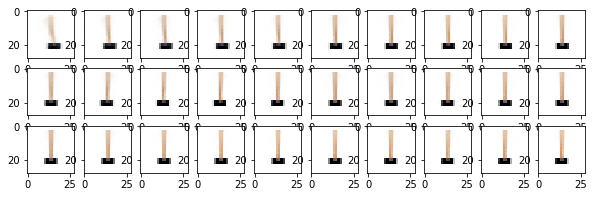

 50%|█████     | 101/200 [06:05<05:57,  3.61s/it]

Epoch: 101 Train loss: 2308.0462


 51%|█████     | 102/200 [06:08<05:54,  3.61s/it]

Epoch: 102 Train loss: 2324.2892


 52%|█████▏    | 103/200 [06:12<05:50,  3.61s/it]

Epoch: 103 Train loss: 2284.1214


 52%|█████▏    | 104/200 [06:15<05:46,  3.61s/it]

Epoch: 104 Train loss: 2265.7720


 52%|█████▎    | 105/200 [06:19<05:43,  3.61s/it]

Epoch: 105 Train loss: 2280.9683


 53%|█████▎    | 106/200 [06:23<05:39,  3.61s/it]

Epoch: 106 Train loss: 2278.7626


 54%|█████▎    | 107/200 [06:26<05:36,  3.61s/it]

Epoch: 107 Train loss: 2257.5211


 54%|█████▍    | 108/200 [06:30<05:32,  3.61s/it]

Epoch: 108 Train loss: 2234.3032


 55%|█████▍    | 109/200 [06:33<05:28,  3.61s/it]

Epoch: 109 Train loss: 2229.8583


 55%|█████▌    | 110/200 [06:37<05:25,  3.61s/it]

Epoch: 110 Train loss: 2219.9134


 56%|█████▌    | 111/200 [06:41<05:21,  3.61s/it]

Epoch: 111 Train loss: 2224.8225


 56%|█████▌    | 112/200 [06:44<05:17,  3.61s/it]

Epoch: 112 Train loss: 2214.2873


 56%|█████▋    | 113/200 [06:48<05:14,  3.61s/it]

Epoch: 113 Train loss: 2215.9229


 57%|█████▋    | 114/200 [06:51<05:10,  3.61s/it]

Epoch: 114 Train loss: 2185.8746


 57%|█████▊    | 115/200 [06:55<05:07,  3.61s/it]

Epoch: 115 Train loss: 2155.6337


 58%|█████▊    | 116/200 [06:59<05:03,  3.61s/it]

Epoch: 116 Train loss: 2166.5751


 58%|█████▊    | 117/200 [07:02<04:59,  3.61s/it]

Epoch: 117 Train loss: 2183.6833


 59%|█████▉    | 118/200 [07:06<04:56,  3.61s/it]

Epoch: 118 Train loss: 2178.7413


 60%|█████▉    | 119/200 [07:09<04:52,  3.61s/it]

Epoch: 119 Train loss: 2176.9099


 60%|██████    | 120/200 [07:13<04:48,  3.61s/it]

Epoch: 120 Train loss: 2140.1265


 60%|██████    | 121/200 [07:17<04:45,  3.61s/it]

Epoch: 121 Train loss: 2156.4029


 61%|██████    | 122/200 [07:20<04:41,  3.61s/it]

Epoch: 122 Train loss: 2173.6097


 62%|██████▏   | 123/200 [07:24<04:38,  3.61s/it]

Epoch: 123 Train loss: 2193.6018


 62%|██████▏   | 124/200 [07:27<04:34,  3.61s/it]

Epoch: 124 Train loss: 2173.5100


 62%|██████▎   | 125/200 [07:31<04:30,  3.61s/it]

Epoch: 125 Train loss: 2156.6492


 63%|██████▎   | 126/200 [07:34<04:27,  3.61s/it]

Epoch: 126 Train loss: 2154.5458


 64%|██████▎   | 127/200 [07:38<04:23,  3.61s/it]

Epoch: 127 Train loss: 2150.1409


 64%|██████▍   | 128/200 [07:42<04:19,  3.61s/it]

Epoch: 128 Train loss: 2116.7759


 64%|██████▍   | 129/200 [07:45<04:16,  3.61s/it]

Epoch: 129 Train loss: 2135.7731


 65%|██████▌   | 130/200 [07:49<04:12,  3.61s/it]

Epoch: 130 Train loss: 2134.5957


 66%|██████▌   | 131/200 [07:52<04:09,  3.61s/it]

Epoch: 131 Train loss: 2127.2941


 66%|██████▌   | 132/200 [07:56<04:05,  3.61s/it]

Epoch: 132 Train loss: 2134.8713


 66%|██████▋   | 133/200 [08:00<04:01,  3.61s/it]

Epoch: 133 Train loss: 2120.6945


 67%|██████▋   | 134/200 [08:03<03:58,  3.61s/it]

Epoch: 134 Train loss: 2106.6445


 68%|██████▊   | 135/200 [08:07<03:54,  3.61s/it]

Epoch: 135 Train loss: 2097.3347


 68%|██████▊   | 136/200 [08:10<03:51,  3.61s/it]

Epoch: 136 Train loss: 2101.1914


 68%|██████▊   | 137/200 [08:14<03:47,  3.61s/it]

Epoch: 137 Train loss: 2117.9972


 69%|██████▉   | 138/200 [08:18<03:43,  3.61s/it]

Epoch: 138 Train loss: 2132.0983


 70%|██████▉   | 139/200 [08:21<03:40,  3.61s/it]

Epoch: 139 Train loss: 2101.7289


 70%|███████   | 140/200 [08:25<03:36,  3.61s/it]

Epoch: 140 Train loss: 2107.9268


 70%|███████   | 141/200 [08:29<03:33,  3.61s/it]

Epoch: 141 Train loss: 2086.3469


 71%|███████   | 142/200 [08:32<03:29,  3.61s/it]

Epoch: 142 Train loss: 2075.3563


 72%|███████▏  | 143/200 [08:36<03:25,  3.61s/it]

Epoch: 143 Train loss: 2090.5236


 72%|███████▏  | 144/200 [08:39<03:22,  3.61s/it]

Epoch: 144 Train loss: 2110.3560


 72%|███████▎  | 145/200 [08:43<03:18,  3.61s/it]

Epoch: 145 Train loss: 2131.0744


 73%|███████▎  | 146/200 [08:47<03:15,  3.61s/it]

Epoch: 146 Train loss: 2099.7526


 74%|███████▎  | 147/200 [08:50<03:11,  3.61s/it]

Epoch: 147 Train loss: 2102.8599


 74%|███████▍  | 148/200 [08:54<03:07,  3.61s/it]

Epoch: 148 Train loss: 2086.2113


 74%|███████▍  | 149/200 [08:58<03:04,  3.61s/it]

Epoch: 149 Train loss: 2083.9986
Epoch: 150 Train loss: 2059.0031


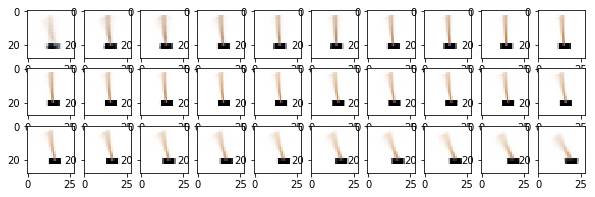

 76%|███████▌  | 151/200 [09:07<02:57,  3.62s/it]

Epoch: 151 Train loss: 2065.1667


 76%|███████▌  | 152/200 [09:10<02:53,  3.62s/it]

Epoch: 152 Train loss: 2061.5811


 76%|███████▋  | 153/200 [09:14<02:50,  3.62s/it]

Epoch: 153 Train loss: 2064.1517


 77%|███████▋  | 154/200 [09:17<02:46,  3.62s/it]

Epoch: 154 Train loss: 2077.5969


 78%|███████▊  | 155/200 [09:21<02:43,  3.62s/it]

Epoch: 155 Train loss: 2072.4356


 78%|███████▊  | 156/200 [09:25<02:39,  3.62s/it]

Epoch: 156 Train loss: 2047.8531


 78%|███████▊  | 157/200 [09:28<02:35,  3.62s/it]

Epoch: 157 Train loss: 2061.1302


 79%|███████▉  | 158/200 [09:32<02:32,  3.62s/it]

Epoch: 158 Train loss: 2069.8052


 80%|███████▉  | 159/200 [09:36<02:28,  3.62s/it]

Epoch: 159 Train loss: 2069.3980


 80%|████████  | 160/200 [09:39<02:24,  3.62s/it]

Epoch: 160 Train loss: 2065.0577


 80%|████████  | 161/200 [09:43<02:21,  3.62s/it]

Epoch: 161 Train loss: 2066.5313


 81%|████████  | 162/200 [09:46<02:17,  3.62s/it]

Epoch: 162 Train loss: 2059.9744


 82%|████████▏ | 163/200 [09:50<02:14,  3.62s/it]

Epoch: 163 Train loss: 2054.1571


 82%|████████▏ | 164/200 [09:54<02:10,  3.62s/it]

Epoch: 164 Train loss: 2056.8596


 82%|████████▎ | 165/200 [09:57<02:06,  3.62s/it]

Epoch: 165 Train loss: 2045.7509


 83%|████████▎ | 166/200 [10:01<02:03,  3.62s/it]

Epoch: 166 Train loss: 2044.3063


 84%|████████▎ | 167/200 [10:04<01:59,  3.62s/it]

Epoch: 167 Train loss: 2059.9163


 84%|████████▍ | 168/200 [10:08<01:55,  3.62s/it]

Epoch: 168 Train loss: 2055.8316


 84%|████████▍ | 169/200 [10:12<01:52,  3.62s/it]

Epoch: 169 Train loss: 2054.1673


 85%|████████▌ | 170/200 [10:15<01:48,  3.62s/it]

Epoch: 170 Train loss: 2057.5113


 86%|████████▌ | 171/200 [10:19<01:45,  3.62s/it]

Epoch: 171 Train loss: 2039.2451


 86%|████████▌ | 172/200 [10:22<01:41,  3.62s/it]

Epoch: 172 Train loss: 2048.7624


 86%|████████▋ | 173/200 [10:26<01:37,  3.62s/it]

Epoch: 173 Train loss: 2038.8059


 87%|████████▋ | 174/200 [10:30<01:34,  3.62s/it]

Epoch: 174 Train loss: 2045.0179


 88%|████████▊ | 175/200 [10:33<01:30,  3.62s/it]

Epoch: 175 Train loss: 2051.1847


 88%|████████▊ | 176/200 [10:37<01:26,  3.62s/it]

Epoch: 176 Train loss: 2047.7569


 88%|████████▊ | 177/200 [10:41<01:23,  3.62s/it]

Epoch: 177 Train loss: 2054.5523


 89%|████████▉ | 178/200 [10:44<01:19,  3.62s/it]

Epoch: 178 Train loss: 2054.5020


 90%|████████▉ | 179/200 [10:48<01:16,  3.62s/it]

Epoch: 179 Train loss: 2039.3899


 90%|█████████ | 180/200 [10:51<01:12,  3.62s/it]

Epoch: 180 Train loss: 2031.6774


 90%|█████████ | 181/200 [10:55<01:08,  3.62s/it]

Epoch: 181 Train loss: 2032.9211


 91%|█████████ | 182/200 [10:59<01:05,  3.62s/it]

Epoch: 182 Train loss: 2044.1339


 92%|█████████▏| 183/200 [11:02<01:01,  3.62s/it]

Epoch: 183 Train loss: 2031.1374


 92%|█████████▏| 184/200 [11:06<00:57,  3.62s/it]

Epoch: 184 Train loss: 2026.4737


 92%|█████████▎| 185/200 [11:10<00:54,  3.62s/it]

Epoch: 185 Train loss: 2011.9869


 93%|█████████▎| 186/200 [11:13<00:50,  3.62s/it]

Epoch: 186 Train loss: 2016.1472


 94%|█████████▎| 187/200 [11:17<00:47,  3.62s/it]

Epoch: 187 Train loss: 2029.9464


 94%|█████████▍| 188/200 [11:20<00:43,  3.62s/it]

Epoch: 188 Train loss: 2050.0365


 94%|█████████▍| 189/200 [11:24<00:39,  3.62s/it]

Epoch: 189 Train loss: 2049.2701


 95%|█████████▌| 190/200 [11:28<00:36,  3.62s/it]

Epoch: 190 Train loss: 2027.0438


 96%|█████████▌| 191/200 [11:31<00:32,  3.62s/it]

Epoch: 191 Train loss: 2032.3673


 96%|█████████▌| 192/200 [11:35<00:28,  3.62s/it]

Epoch: 192 Train loss: 2024.0881


 96%|█████████▋| 193/200 [11:38<00:25,  3.62s/it]

Epoch: 193 Train loss: 2026.0871


 97%|█████████▋| 194/200 [11:42<00:21,  3.62s/it]

Epoch: 194 Train loss: 2024.8037


 98%|█████████▊| 195/200 [11:46<00:18,  3.62s/it]

Epoch: 195 Train loss: 2015.4725


 98%|█████████▊| 196/200 [11:49<00:14,  3.62s/it]

Epoch: 196 Train loss: 2007.3981


 98%|█████████▊| 197/200 [11:53<00:10,  3.62s/it]

Epoch: 197 Train loss: 2016.8807


 99%|█████████▉| 198/200 [11:57<00:07,  3.62s/it]

Epoch: 198 Train loss: 2011.6728


100%|█████████▉| 199/200 [12:00<00:03,  3.62s/it]

Epoch: 199 Train loss: 2007.1013
Epoch: 200 Train loss: 2017.4889


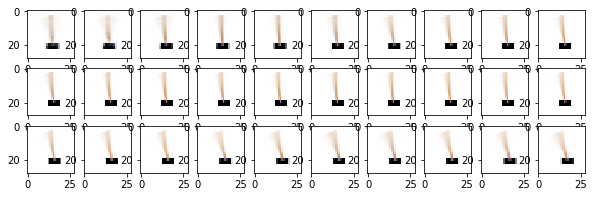

100%|██████████| 200/200 [12:06<00:00,  3.63s/it]


In [10]:
epochs = 200
for epoch in tqdm(range(1, epochs + 1)):
    train_loss = data_loop(epoch, train_loader, dmm, device, train_mode=True)
    # test_loss = data_loop(epoch, test_loader, dmm, device)
    sample = plot_video_from_latent(batch_size)#[:, None][1,:] # 128, 30, 2352
    if epoch % 50 == 0:
        plt.figure(figsize=(10,3))
        for i in range(30):
            plt.subplot(3,10,i+1)
            plt.imshow(sample[0][i].cpu().detach().numpy().astype(np.float).reshape(3,28,28).transpose(1,2,0))
        plt.show()

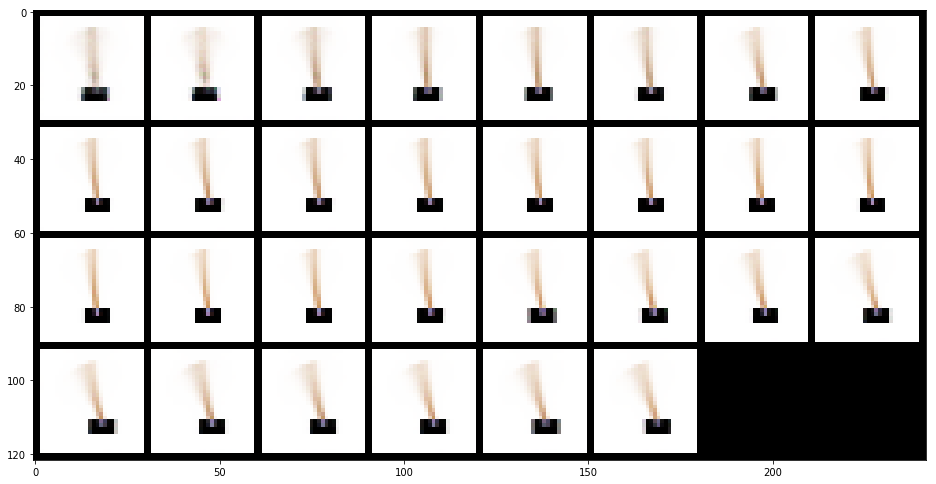

In [16]:
imshow(sample[0].cpu().detach())

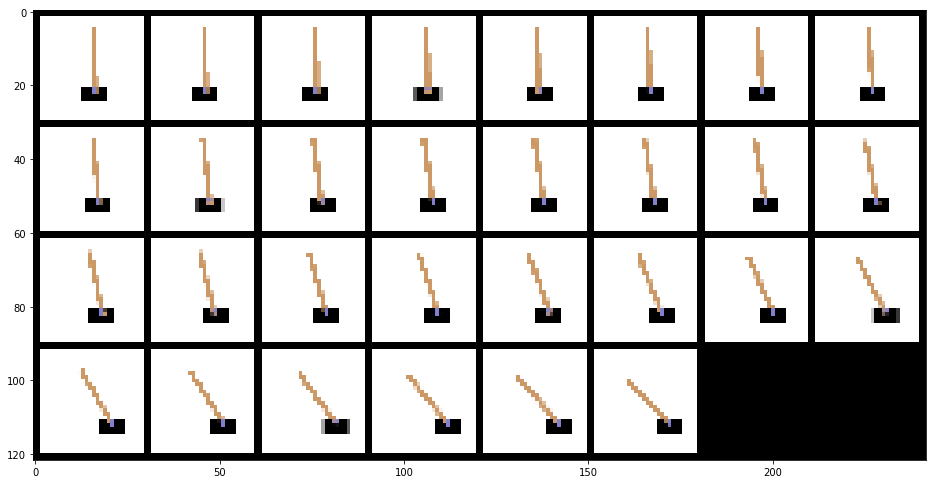

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.]])


In [26]:
imshow(_data["episode_frames"][0])
print(_data["actions"][0])